## Foundational Project 1

PART 1. Data Pre-processing

Step #0. Fire the system

In [131]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

Step #1. Read data

In [132]:
df_news = pd.read_csv("Reliance_sentiment.csv")
df_price = pd.read_csv("reliance_prices.csv")

df_news['date'] = pd.to_datetime(df_news.date)
df_price['Date'] = pd.to_datetime(df_price.Date)

df_combined = pd.merge(left=df_price,right=df_news,how="left",left_on = 'Date',right_on='date')
df_combined.drop(['date'],axis=1,inplace=True)

# Impute all the NaN with 0 as the sentiment score.

df_combined.fillna(0.0,inplace=True)


cols = list(df_combined.columns)
a, b = cols.index('Open'), cols.index('Adj Close')
cols[b], cols[a] = cols[a], cols[b]
df_combined = df_combined[cols]

df_combined = df_combined.drop(['High','Low', 'Close', 'Open', 'Volume', 'SMA5', 'SMA9', 'SMA15', 'SMA30', 'EMA5', 'EMA9', 'EMA15', 'EMA30',  'avg_senti_comp', 'title_senti_comp'],axis=1)


# Select features (columns) to be involved into training and predictions
cols = list(df_combined)[1:24]

df_combined



,Date,Adj Close,1d_diff,5d_diff,10d_diff,SMA3,EMA3,Volume_100k,news_senti_comp
0,2016-12-13,501.832367,-9.757507,-8.965027,-12.333130,511.146505,510.925976,47.838,0.000000
1,2016-12-14,511.339996,3.244202,-1.857422,4.853943,516.190358,517.850805,111.403,0.730367
2,2016-12-15,508.178925,-2.080261,-0.198120,-6.191284,520.441732,519.691119,89.217,0.000000
3,2016-12-16,510.205872,-2.674622,-0.074280,-12.506470,523.306254,521.651407,68.958,0.000000
4,2016-12-19,512.812012,2.303162,7.479065,-11.169128,523.809814,523.968861,69.269,0.000000
...,...,...,...,...,...,...,...,...,...
1379,2022-07-11,2423.899902,3.449951,1.649902,3.500000,2401.133301,2411.709763,63.906,0.000000
1380,2022-07-12,2420.449951,42.899902,-16.650146,-1.050049,2411.916585,2416.079857,49.745,0.000000
1381,2022-07-13,2377.550049,-19.599854,-125.449951,-41.649902,2407.299967,2396.814953,65.644,-0.077200
1382,2022-07-14,2397.149902,-4.650146,-89.150146,-59.950195,2398.383301,2396.982428,78.318,0.470300


In [133]:
# Extract dates (will be used in visualization)
datelist_train = list(df_combined['Date'])
df_combined = df_combined.drop('Date', axis=1)
df_combined.head()

print('Training set shape == {}'.format(df_combined.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Feature selected: {}'.format(cols))

#df_combined.to_csv("Finance with sentiment_trial.csv",encoding="utf-8", index='Date')


Training set shape == (1384, 8)
All timestamps == 1384
Feature selected: ['Adj Close', '1d_diff', '5d_diff', '10d_diff', 'SMA3', 'EMA3', 'Volume_100k', 'news_senti_comp']


Step #2. Data pre-processing

Removing all commas and convert data to matrix shape format.

In [134]:
df_combined = df_combined[cols].astype(str)
for i in cols:
    for j in range(0, len(df_combined)):
        df_combined[i][j] = df_combined[i][j].replace(',', '')

df_combined = df_combined.astype(float)

# Using multiple features (predictors)
training_set = df_combined.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1384, 8).


array([[ 5.01832367e+02, -9.75750732e+00, -8.96502686e+00, ...,
         5.10925976e+02,  4.78380000e+01,  0.00000000e+00],
       [ 5.11339996e+02,  3.24420166e+00, -1.85742188e+00, ...,
         5.17850805e+02,  1.11403000e+02,  7.30366667e-01],
       [ 5.08178925e+02, -2.08026123e+00, -1.98120117e-01, ...,
         5.19691119e+02,  8.92170000e+01,  0.00000000e+00],
       ...,
       [ 2.37755005e+03, -1.95998535e+01, -1.25449951e+02, ...,
         2.39681495e+03,  6.56440000e+01, -7.72000000e-02],
       [ 2.39714990e+03, -4.65014648e+00, -8.91501465e+01, ...,
         2.39698243e+03,  7.83180000e+01,  4.70300000e-01],
       [ 2.40180005e+03, -2.04499512e+01, -1.01300049e+02, ...,
         2.39939124e+03,  4.43190000e+01,  0.00000000e+00]])

In [135]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.5495049 ],
       [-1.53464199],
       [-1.53958357],
       ...,
       [ 1.38273276],
       [ 1.41337246],
       [ 1.42064186]])

In [136]:
# Creating a data structure with 50 timestamps and 1 output
X_train = []
y_train = []

n_future = 10   # Number of days we want to predict into the future
n_past = 500     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df_combined.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (875, 500, 7).
y_train shape == (875, 1).


PART 2. Create a model. Training

Step #3. Building the LSTM based Neural Network

In [137]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [138]:
df_combined.shape[1]-1

7

In [139]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_combined.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

Step #4. Start training

In [140]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 0.3158
Epoch 1: val_loss improved from inf to 0.39366, saving model to weights.h5
3/3 [==============================] - 10s 3s/step - loss: 0.3158 - val_loss: 0.3937 - lr: 0.0100
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.1050
Epoch 2: val_loss improved from 0.39366 to 0.16039, saving model to weights.h5
3/3 [==============================] - 8s 3s/step - loss: 0.1050 - val_loss: 0.1604 - lr: 0.0100
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 0.0630
Epoch 3: val_loss did not improve from 0.16039
3/3 [==============================] - 8s 2s/step - loss: 0.0630 - val_loss: 0.1769 - lr: 0.0100
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.0428
Epoch 4: val_loss improved from 0.16039 to 0.02532, saving model to weights.h5
3/3 [==============================] - 7s 2s/step - loss: 0.0428 - val_loss: 0.0253 - lr: 0.0100
Epoch 5/30
3/3 [=======================

Notes:
- EarlyStopping - Stop training when a monitored metric has stopped improving.
- monitor - quantity to be monitored.
- min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- patience - number of epochs with no improvement after which training will be stopped.
- ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
- factor - factor by which the learning rate will be reduced. new_lr = lr * factor.

PART 3. Make future predictions

In [141]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='7d').tolist()

'''
Remember, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

Step #5. Make predictions for future dates

In [142]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

12/12 [==============================] - 2s 136ms/step


In [143]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Adj Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Adj Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN

,Adj Close
2021-01-12,1934.911377
2021-01-13,1944.749268
2021-01-14,1965.608398
2021-01-15,1975.073364
2021-01-18,1987.115723
...,...
2022-07-11,2351.821533
2022-07-12,2366.435059
2022-07-13,2346.842285
2022-07-14,2320.711670


In [144]:
PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index.to_series().apply(datetime_to_timestamp)
PREDICTIONS_FUTURE.head()

,Adj Close
2022-07-15,2419.726074
2022-07-22,2389.582275
2022-07-29,2366.820068
2022-08-05,2343.198242
2022-08-12,2331.730225


Step #6. Visualize the Predictions

In [145]:
# Parse training set timestamp for better visualization
df_combined = pd.DataFrame(df_combined, columns=cols)
df_combined.index = datelist_train
df_combined.index = pd.to_datetime(df_combined.index)

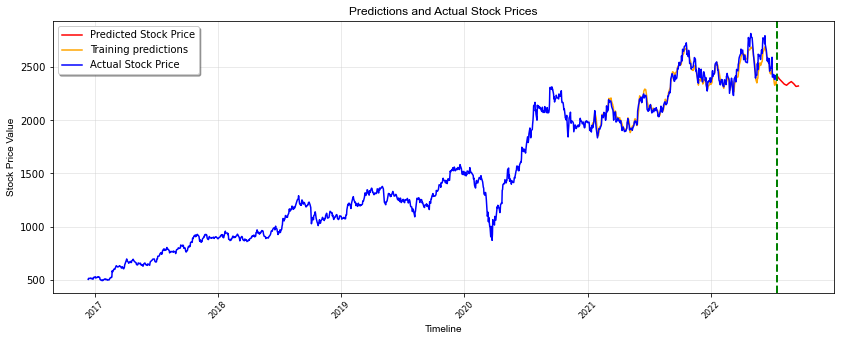

In [146]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2016-12-13'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Adj Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Adj Close'], color='orange', label='Training predictions')
plt.plot(df_combined.loc[START_DATE_FOR_PLOTTING:].index, df_combined.loc[START_DATE_FOR_PLOTTING:]['Adj Close'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

Saving the model

In [147]:

# save model and architecture to single file
model.save("model_new1.h5")
print("Saved model to disk")

Saved model to disk
